In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from sklearn.ensemble import RandomForestRegressor
#from xgboost.sklearn import XGBRegressor
#from sklearn import preprocessing, svm

import statsmodels.tsa.api as smt

import pickle
import math

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [4]:
from tensorflow.keras.layers import Dropout

In [5]:
series = pd.read_excel('LFP 1C.xlsx')
data = series

In [6]:
data.head()

,Cycle,Capacity
0,1,100.000000
1,2,99.961388
2,3,99.922789
3,4,99.884202
4,5,99.845628


In [6]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Capacity')
    
    #second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    #second.date = pd.to_datetime(second.date, format='%Y')
    #sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Cycle",
           ylabel = "Capacity",
           title = title)
    
    sns.despine()

In [7]:
data['capacity_diff'] = data['Capacity'].diff()
data = data.dropna()

In [8]:
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,7):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['capacity_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    #supervised_df.to_csv('../data/model_df.csv', index=False)
    
    return supervised_df

In [9]:
def train_test_split(data, n_test):
	return data[:n_test], data[n_test:]

In [10]:
model_df = generate_supervised(data)
real = pd.read_excel('Data Degradasi 80 Cycle Skenario 2.xlsx')
real = real.drop('Cycle', axis = 1)
model_df['Real'] = real
model_df = model_df.drop(['Cycle'], axis=1)
train_set, test_set = train_test_split(model_df, 80);

In [11]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.values.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.values.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    #X_train, y_train = train_set[:, :-1], train_set[:, -1:]
    #X_test, y_test = test_set[:, :-1], test_set[:, -1:]
    
    X_train, y_train = train_set_scaled[:, :-1], train_set_scaled[:, -1:]
    X_test, y_test = test_set_scaled[:, :-1], test_set_scaled[:, -1:]
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train_set, test_set) 

In [12]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_excel('Data Degradasi 80 Cycle Skenario 2.xlsx')
    #original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    #original_df = original_df.groupby('date')['sales'].sum().reset_index()
    #original_df.date = pd.to_datetime(original_df.date)
    
    return original_df

In [13]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=True):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [14]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    cycle = list(series[80:]['Cycle'])
    #capacity = list(original_df[80:]['Capacity'])
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0])
        result_dict['Cycle'] = cycle[index]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [15]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(model_df['Capacity'][80:], unscaled_df.pred_value))
    mae = mean_absolute_error(model_df['Capacity'][80:], unscaled_df.pred_value)
    r2 = r2_score(model_df['Capacity'][80:], unscaled_df.pred_value)
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [16]:
def combine_data(original_df, unscaled_df):
    alldata = pd.concat([original_df['Capacity'], unscaled_df['pred_value']], ignore_index=True)
    cycle = pd.DataFrame(np.arange(len(alldata)), columns = ['Cycle'])
    alldata = pd.DataFrame(alldata, columns = ['Capacity'])
    alldata['Cycle'] = cycle
    
    return alldata

In [32]:
def plot_results(alldata, model_name):

    fig, ax = plt.subplots(figsize=(8,5))
    sns.lineplot(alldata['Cycle'][:80], alldata['Capacity'][:80], data=alldata, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(alldata['Cycle'][80:], alldata['Capacity'][80:], data=alldata, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Siklus",
           ylabel = "Kapasitas",
           title = f"Prediksi Penurunan Kapasitas dengan {model_name}")
    
    ax.legend()
    
    sns.despine()
    
    #plt.savefig(f'../model_output/{model_name}_forecast.png')

In [18]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [19]:
model = Sequential()
model.add(LSTM(50, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True, return_sequences=True))
model.add(LSTM(50, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True, return_sequences=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
history = model.fit(X_train, y_train, epochs=80, batch_size=1, verbose=1, 
            shuffle=False)

Train on 80 samples
Epoch 1/80
80/80 [==============================] - 6s 75ms/sample - loss: 0.1306
Epoch 2/80
80/80 [==============================] - 0s 4ms/sample - loss: 0.1812
Epoch 3/80
80/80 [==============================] - 0s 4ms/sample - loss: 0.1174
Epoch 4/80
80/80 [==============================] - 0s 4ms/sample - loss: 0.0905
Epoch 5/80
80/80 [==============================] - 0s 4ms/sample - loss: 0.0370
Epoch 6/80
80/80 [==============================] - 0s 4ms/sample - loss: 0.0224
Epoch 7/80
80/80 [==============================] - 0s 4ms/sample - loss: 0.0105
Epoch 8/80
80/80 [==============================] - 0s 4ms/sample - loss: 0.0034
Epoch 9/80
80/80 [==============================] - 0s 4ms/sample - loss: 0.0011
Epoch 10/80
80/80 [==============================] - 0s 4ms/sample - loss: 8.1047e-04
Epoch 11/80
80/80 [==============================] - 0s 4ms/sample - loss: 0.0010
Epoch 12/80
80/80 [==============================] - 0s 4ms/sample - loss: 7.5376e

In [21]:
predictions = model.predict(X_test,batch_size=1)

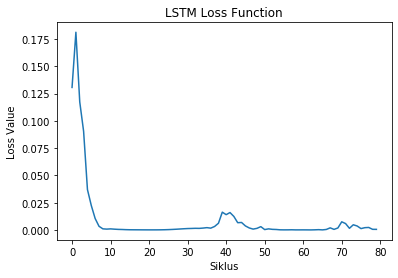

In [23]:
plt.plot(history.history['loss'])
plt.ylabel('Loss Value')
plt.xlabel('Siklus')
plt.title('LSTM Loss Function')
plt.show()

In [24]:
original_df = load_original_df()

In [25]:
unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)

In [26]:
unscaled_df = predict_df(unscaled, original_df)

In [27]:
get_scores(unscaled_df, original_df, "LSTM")

RMSE: 10.63202278995335
MAE: 9.194482170406605
R2 Score: -3.3689208677053637


In [28]:
alldata = combine_data(original_df, unscaled_df)

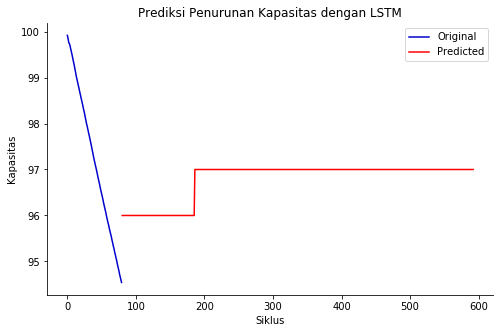

In [33]:
plot_results(alldata, 'LSTM')

In [193]:
original_data = pd.DataFrame(data=y_train, columns=["Original"])

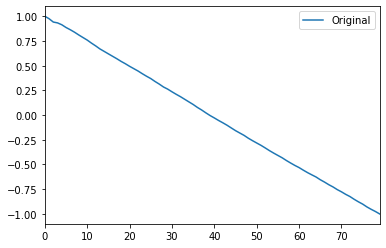

In [194]:
original_data.plot()

In [210]:
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

In [211]:
prediction_data = pd.DataFrame(data=predictions, columns=["Prediction"])

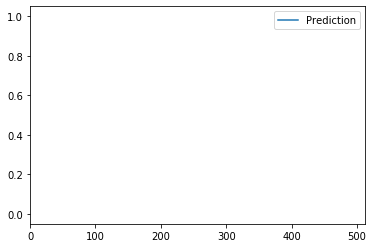

In [212]:
prediction_data.plot()

In [198]:
all_data = pd.concat([original_data['Original'], prediction_data['Prediction']], ignore_index=True)

In [164]:
original_data

,Original
0,1.000000
1,0.974989
2,0.941274
3,0.932815
4,0.913954
...,...
75,-0.900778
76,-0.929228
77,-0.953353
78,-0.975429


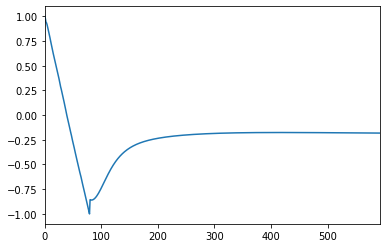

In [199]:
all_data.plot()

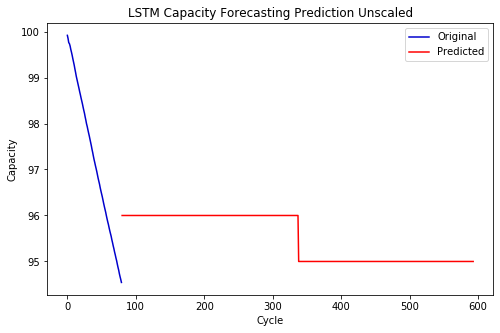

In [156]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(alldata['Cycle'][:80], alldata['Capacity'][:80], data=alldata, ax=ax, 
             label='Original', color='mediumblue')
sns.lineplot(alldata['Cycle'][80:], alldata['Capacity'][80:], data=alldata, ax=ax, 
             label='Predicted', color='Red')
    
ax.set(xlabel = "Cycle",
       ylabel = "Capacity",
       title = "LSTM Capacity Forecasting Prediction Unscaled")
    
ax.legend()